# Bitcoin price forecasting

## Jakub Koral

In [3]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch

C:\Users\jakub\AppData\Local\Temp\ipykernel_15708\2672865222.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Exploratory data analysis

We download data concerning exchange rates of Bitcoin and American dollars from Yahoo Finance website from Janaury 1, 2020 until January 1, 2024.

In [4]:
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2024, 1, 1)
data = yf.download("BTC-USD", start_date, end_date)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055


In the further work we will only work on Close prices.

In [5]:
data["Close"].describe()

count     1461.000000
mean     28890.454091
std      15114.075467
min       4970.788086
25%      16967.132812
50%      27307.437500
75%      39773.828125
max      67566.828125
Name: Close, dtype: float64

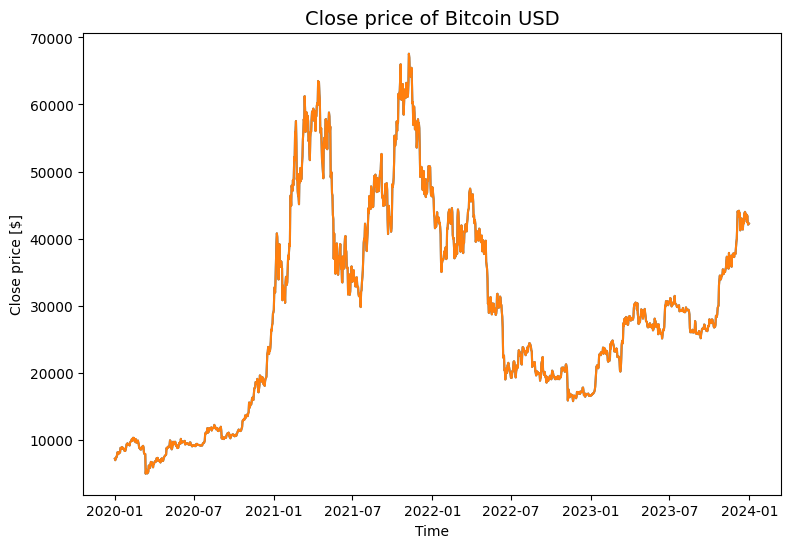

In [6]:
fig = plt.figure(figsize=(9, 6))
plt.plot(data.index, data["Close"])
plt.plot(data["Close"])
plt.xlabel("Time")
plt.ylabel("Close price [$]")
plt.title("Close price of Bitcoin USD", size=14)
plt.show()

We can observe that Bitcoin was the most valuable at the beginning and at the end of 2021. Its value was relatively low in 2022. Since January 2023 it expirences a growth in value.

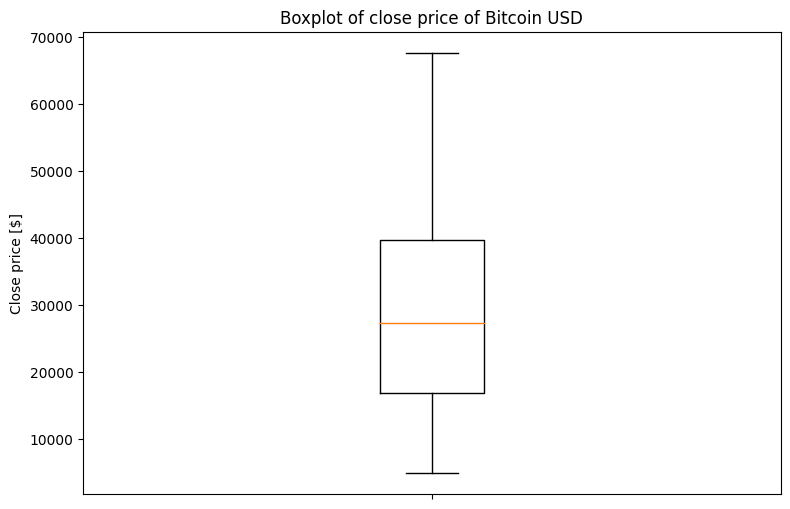

In [7]:
fig = plt.figure(figsize=(9, 6))
plt.boxplot(data["Close"])
plt.title("Boxplot of close price of Bitcoin USD")
plt.ylabel("Close price [$]")
plt.xticks([1], [""])
plt.show()

The close price of Bitcoin is right skewed, there are no outliers.

## Forecasting

### Data preprocessing

In [15]:
# splitting into train and testsets
split_point = int(0.8 * data.shape[0])
train_data = data["Close"].values[:split_point].reshape((-1, 1))
test_data = data["Close"].values[split_point:].reshape((-1, 1))

# scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)

# Splitting into X and y
X_train = []
y_train = []
for i in range(50, len(train_data)):
    X_train.append(train_data[i-50:i, 0])
    y_train.append(train_data[i, 0])

X_test = []
y_test = []
for i in range(50, len(test_data)):
    X_test.append(test_data[i-50:i, 0])
    y_test.append(test_data[i, 0])

# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

y_true = scaler.inverse_transform(y_test)

### Simple model

In [45]:
simple_model = Sequential(name="simple_model")
simple_model.add(SimpleRNN(50, activation="relu", return_sequences=True, input_shape=X_train[0].shape))
simple_model.add(Dropout(0.2))
simple_model.add(SimpleRNN(50, activation="relu", return_sequences=True))
simple_model.add(SimpleRNN(50, activation="relu", return_sequences=True))
simple_model.add(SimpleRNN(50))
simple_model.add(Dense(1, activation="sigmoid"))
simple_model.compile(loss="mean_squared_error", optimizer="adam")

In [46]:
simple_model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 50, 50)            2600      
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 17801 (69.54 KB)
Trainable params: 17801

In [47]:
results_simple = simple_model.fit(X_train, y_train, epochs=10, batch_size=1)

Epoch 1/10


1118/1118 [==============================] - 25s 21ms/step - loss: 0.0065
Epoch 2/10
1118/1118 [==============================] - 24s 21ms/step - loss: 0.0025
Epoch 3/10
1118/1118 [==============================] - 24s 21ms/step - loss: 0.0018
Epoch 4/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0017
Epoch 5/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0013
Epoch 6/10
1118/1118 [==============================] - 24s 21ms/step - loss: 0.0012
Epoch 7/10
1118/1118 [==============================] - 25s 22ms/step - loss: 0.0011
Epoch 8/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0013
Epoch 9/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0011
Epoch 10/10
1118/1118 [==============================] - 24s 21ms/step - loss: 0.0012


In [48]:
def plot_results(results):
    fig = plt.figure(figsize=(9, 6))
    plt.plot(range(1, 11) ,results.history["loss"])
    plt.xticks(range(1, 11))
    plt.xlabel("Epoch")
    plt.ylabel("Mean squared error")
    plt.title("Training history", size=18)
    plt.show()

In [49]:
def plot_comparison(y_pred, y_true, model_name):
    fig = plt.figure(figsize=(9, 6))
    plt.plot(data.index[split_point+50:], y_true, label="true data")
    plt.plot(data.index[split_point+50:], y_pred, label=model_name)
    plt.xlabel("Time")
    plt.ylabel("Close price [$]")
    plt.title("Close price of Bitcoin USD", size=14)
    plt.legend()
    plt.show()

In [50]:
def calculate_errors(y_pred, y_true):
    df = pd.DataFrame(index=["MAE", "RMSE"], columns=["value"])
    errors = [np.mean(np.abs(y_true-y_pred)), np.sqrt(np.mean((y_true-y_pred)**2))]
    df["value"] = errors
    return df

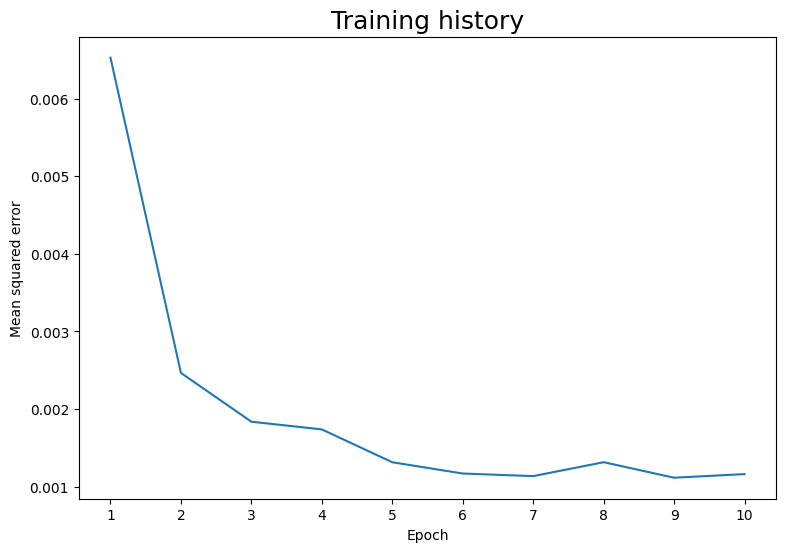

In [51]:
plot_results(results_simple)

In [52]:
prediction_simple = simple_model.predict(X_test)
y_simple = scaler.inverse_transform(prediction_simple)

8/8 [==============================] - 0s 5ms/step


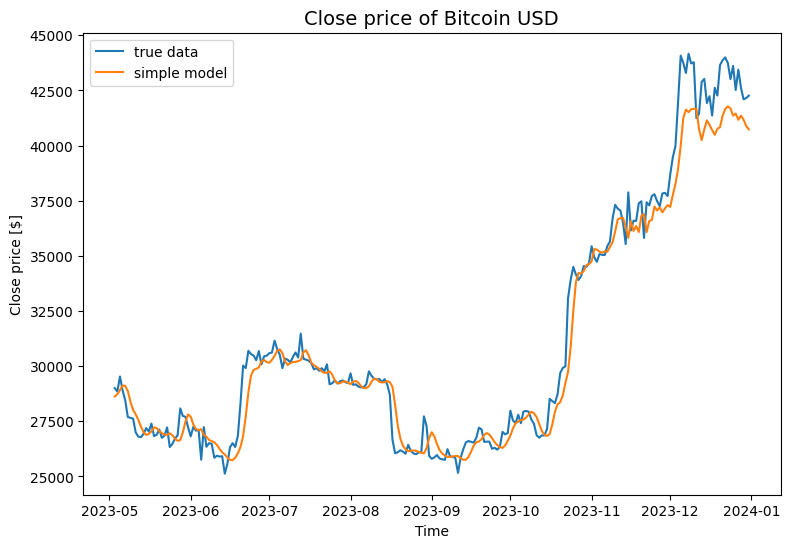

In [53]:
plot_comparison(y_simple, y_true, "simple model")

The simple model performs quite well. It underestimates the increase in value of Bitcoin in December 2023.

In [54]:
calculate_errors(y_simple, y_true)

,value
MAE,685.857124
RMSE,1011.150220


### LSTM

In [46]:
lstm_model = Sequential(name="lstm_model")
lstm_model.add(LSTM(50, return_sequences=True, input_shape=X_train[0].shape))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(loss="mean_squared_error", optimizer="adam")

In [47]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_9 (Dense)             (None, 25)                1275      
                                                                 
 dense_10 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
results_lstm = lstm_model.fit(X_train, y_train, epochs=10, batch_size=1)

Epoch 1/10
1118/1118 [==============================] - 15s 12ms/step - loss: 0.0047
Epoch 2/10
1118/1118 [==============================] - 14s 13ms/step - loss: 0.0017
Epoch 3/10
1118/1118 [==============================] - 12s 11ms/step - loss: 0.0011
Epoch 4/10
1118/1118 [==============================] - 13s 11ms/step - loss: 0.0011
Epoch 5/10
1118/1118 [==============================] - 12s 11ms/step - loss: 8.3487e-04
Epoch 6/10
1118/1118 [==============================] - 12s 11ms/step - loss: 8.1183e-04
Epoch 7/10
1118/1118 [==============================] - 12s 11ms/step - loss: 7.9865e-04
Epoch 8/10
1118/1118 [==============================] - 13s 12ms/step - loss: 7.4442e-04
Epoch 9/10
1118/1118 [==============================] - 13s 12ms/step - loss: 7.2946e-04
Epoch 10/10
1118/1118 [==============================] - 12s 11ms/step - loss: 7.4491e-04


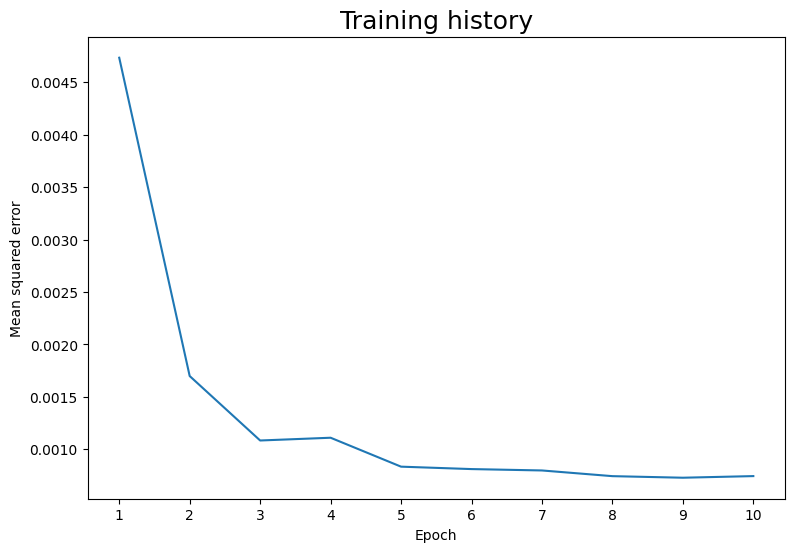

In [49]:
plot_results(results_lstm)

In [50]:
prediction_lstm = lstm_model.predict(X_test)
y_lstm = scaler.inverse_transform(prediction_lstm)

8/8 [==============================] - 1s 8ms/step


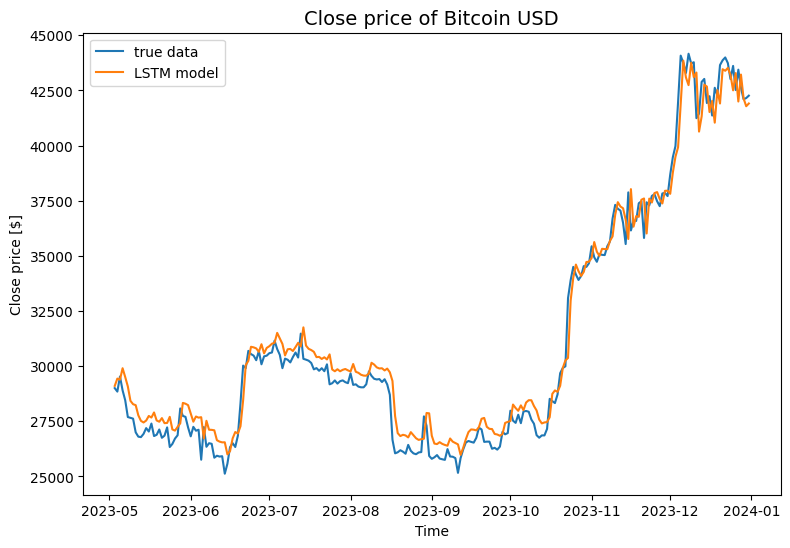

In [51]:
plot_comparison(y_lstm, y_true, "LSTM model")

LSTM model is very good at forecasting since the second half of October 2023. It overestimates the value of Bitcoin for earlier dates.

In [52]:
calculate_errors(y_lstm, y_true)

,value
MAE,644.656049
RMSE,798.096623


### GRU

In [53]:
gru_model = Sequential(name="gru_model")
gru_model.add(GRU(50, activation="relu", return_sequences=True, input_shape=X_train[0].shape))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(50, activation="relu", return_sequences=True))
gru_model.add(GRU(50, activation="relu", return_sequences=True))
gru_model.add(GRU(50, activation="relu"))
gru_model.add(Dense(1, activation="sigmoid"))
gru_model.compile(loss="mean_squared_error", optimizer="adam")

In [54]:
gru_model.summary()

Model: "gru_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50, 50)            15300     
                                                                 
 gru_2 (GRU)                 (None, 50, 50)            15300     
                                                                 
 gru_3 (GRU)                 (None, 50)                15300     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 53901 (210.55 KB)
Trainable params: 53901 (

In [55]:
results_gru = gru_model.fit(X_train, y_train, epochs=10, batch_size=1)

Epoch 1/10


1118/1118 [==============================] - 26s 21ms/step - loss: 0.0089
Epoch 2/10
1118/1118 [==============================] - 23s 20ms/step - loss: 0.0023
Epoch 3/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0018
Epoch 4/10
1118/1118 [==============================] - 22s 20ms/step - loss: 0.0015
Epoch 5/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0014
Epoch 6/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0014
Epoch 7/10
1118/1118 [==============================] - 22s 20ms/step - loss: 0.0011
Epoch 8/10
1118/1118 [==============================] - 24s 21ms/step - loss: 0.0012
Epoch 9/10
1118/1118 [==============================] - 25s 22ms/step - loss: 0.0011
Epoch 10/10
1118/1118 [==============================] - 22s 20ms/step - loss: 0.0010


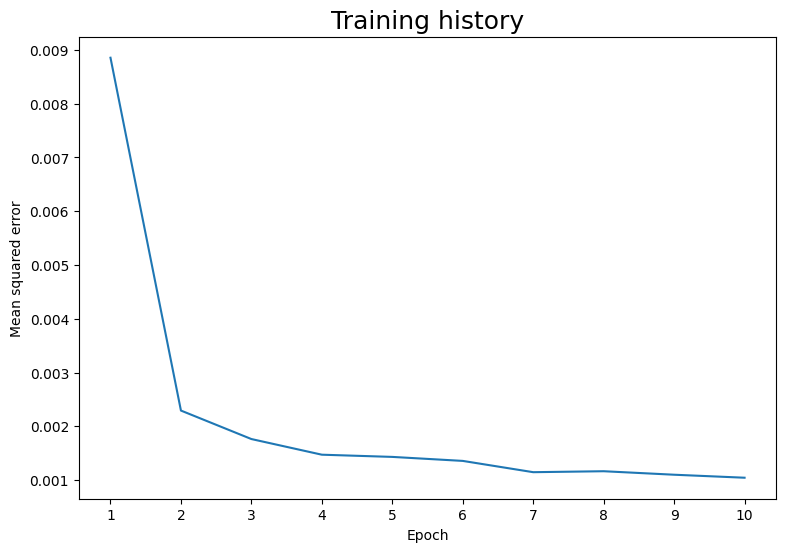

In [56]:
plot_results(results_gru)

In [57]:
prediction_gru = gru_model.predict(X_test)
y_gru = scaler.inverse_transform(prediction_gru)

8/8 [==============================] - 0s 12ms/step


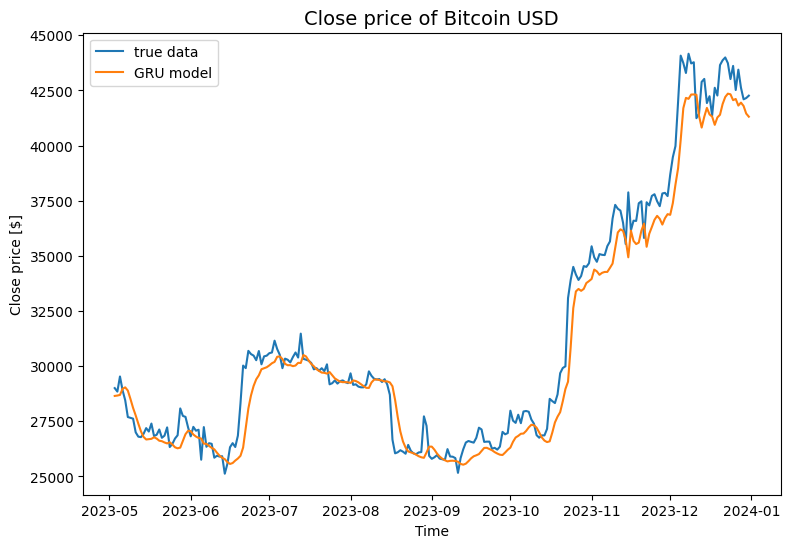

In [58]:
plot_comparison(y_gru, y_true, "GRU model")

GRU model is good at estimating the general trend of the price of Bitcoin, but the estimates seem to be too "smoothed out".

In [59]:
calculate_errors(y_gru, y_true)

,value
MAE,772.866673
RMSE,1072.783493


## Tuning

### Simple model

In [58]:
def simple_hypermodel(hp):

    model = Sequential(name="simple_model_tuned")
    model.add(SimpleRNN(50, activation="relu", return_sequences=True, input_shape=X_train[0].shape))
    model.add(Dropout(hp.Choice("dropout", values=[0.1, 0.15, 0.2, 0.25, 0.3])))
    model.add(SimpleRNN(50, activation="relu", return_sequences=True))
    model.add(SimpleRNN(50, activation="relu", return_sequences=True))
    model.add(SimpleRNN(50))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="mean_squared_error", optimizer="adam")

    return model

In [59]:
tuner_simple = RandomSearch(simple_hypermodel, objective="loss", 
                            max_trials=5, executions_per_trial=3, 
                            directory="results", project_name="simple")

In [60]:
tuner_simple.search(X_train, y_train, epochs=5, batch_size=1)

Trial 5 Complete [00h 05m 54s]
loss: 0.0016842052961389224

Best loss So Far: 0.0013320307480171323
Total elapsed time: 00h 30m 23s


In [61]:
tuner_simple.hypermodel.build(tuner_simple.get_best_hyperparameters()[0])
tuner_simple.results_summary(num_trials=1)

Results summary
Results in results\simple
Showing 1 best trials
Objective(name="loss", direction="min")

Trial 1 summary
Hyperparameters:
dropout: 0.1
Score: 0.0013320307480171323


In [62]:
simple_model_tuned = simple_hypermodel(tuner_simple.get_best_hyperparameters()[0])
results_simple_tuned = simple_model_tuned.fit(X_train, y_train, epochs=10, batch_size=1)

Epoch 1/10
1118/1118 [==============================] - 25s 20ms/step - loss: 0.0052
Epoch 2/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0020
Epoch 3/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0015
Epoch 4/10
1118/1118 [==============================] - 23s 20ms/step - loss: 0.0015
Epoch 5/10
1118/1118 [==============================] - 22s 20ms/step - loss: 0.0013
Epoch 6/10
1118/1118 [==============================] - 23s 21ms/step - loss: 0.0011
Epoch 7/10
1118/1118 [==============================] - 23s 20ms/step - loss: 0.0011
Epoch 8/10
1118/1118 [==============================] - 23s 20ms/step - loss: 0.0010
Epoch 9/10
1118/1118 [==============================] - 23s 21ms/step - loss: 9.9715e-04
Epoch 10/10
1118/1118 [==============================] - 23s 21ms/step - loss: 8.5562e-04


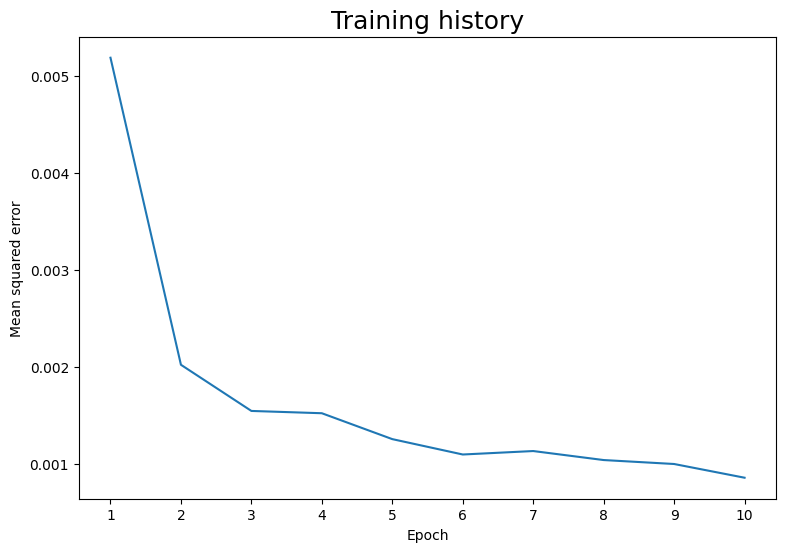

In [63]:
plot_results(results_simple_tuned)

In [64]:
prediction_simple_tuned = simple_model_tuned.predict(X_test)
y_simple_tuned = scaler.inverse_transform(prediction_simple_tuned)

8/8 [==============================] - 0s 6ms/step


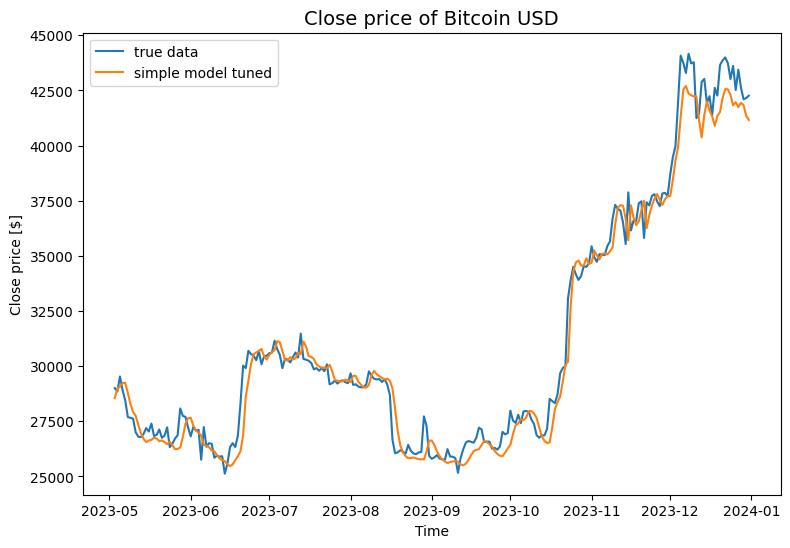

In [65]:
plot_comparison(y_simple_tuned, y_true, "simple model tuned")

In [66]:
calculate_errors(y_simple_tuned, y_true)

,value
MAE,588.58097
RMSE,830.85346


We see a improvement compared to the untuned simple model both in terms of MAE and RMSE.

### LSTM

In [37]:
def lstm_hypermodel(hp):

    model = Sequential(name="lstm_model_tuned")
    model.add(LSTM(50, return_sequences=True, input_shape=X_train[0].shape))
    model.add(LSTM(50))
    for i in range(hp.Int("dense_layers", 1, 4)):
        model.add(Dense(hp.Int(f"dense_layer_{i}", 10, 50, step=5)))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")

    return model

In [38]:
tuner_lstm = RandomSearch(lstm_hypermodel, objective="loss", 
                          max_trials=5, executions_per_trial=3, 
                          directory="results", project_name="lstm")

In [39]:
tuner_lstm.search(X_train, y_train, epochs=5, batch_size=1)

Trial 5 Complete [00h 03m 25s]
loss: 0.0009176441623518864

Best loss So Far: 0.0009176441623518864
Total elapsed time: 00h 16m 56s


In [40]:
tuner_lstm.hypermodel.build(tuner_lstm.get_best_hyperparameters()[0])
tuner_lstm.results_summary(num_trials=1)

Results summary
Results in results\lstm
Showing 1 best trials
Objective(name="loss", direction="min")

Trial 4 summary
Hyperparameters:
dense_layers: 2
dense_layer_0: 30
dense_layer_1: 20
dense_layer_2: 10
dense_layer_3: 30
Score: 0.0009176441623518864


In [41]:
lstm_model_tuned = lstm_hypermodel(tuner_lstm.get_best_hyperparameters()[0])
results_lstm_tuned = lstm_model_tuned.fit(X_train, y_train, epochs=10, batch_size=1)

Epoch 1/10
1118/1118 [==============================] - 16s 12ms/step - loss: 0.0043
Epoch 2/10
1118/1118 [==============================] - 13s 12ms/step - loss: 0.0016
Epoch 3/10
1118/1118 [==============================] - 14s 13ms/step - loss: 0.0011
Epoch 4/10
1118/1118 [==============================] - 14s 12ms/step - loss: 0.0011
Epoch 5/10
1118/1118 [==============================] - 14s 12ms/step - loss: 9.0203e-04
Epoch 6/10
1118/1118 [==============================] - 14s 12ms/step - loss: 7.8369e-04
Epoch 7/10
1118/1118 [==============================] - 14s 12ms/step - loss: 8.4425e-04
Epoch 8/10
1118/1118 [==============================] - 13s 12ms/step - loss: 7.8304e-04
Epoch 9/10
1118/1118 [==============================] - 13s 12ms/step - loss: 8.7732e-04
Epoch 10/10
1118/1118 [==============================] - 13s 12ms/step - loss: 7.1748e-04


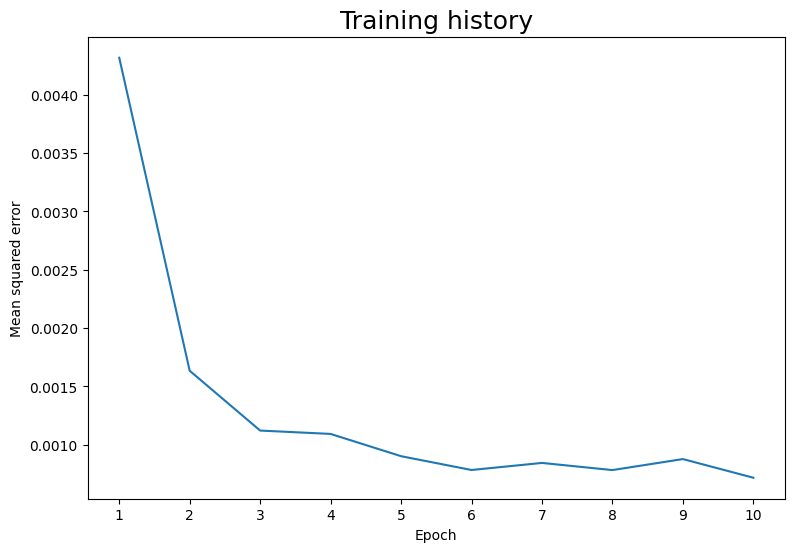

In [42]:
plot_results(results_lstm_tuned)

In [43]:
prediction_lstm_tuned = lstm_model_tuned.predict(X_test)
y_lstm_tuned = scaler.inverse_transform(prediction_lstm_tuned)

8/8 [==============================] - 1s 5ms/step


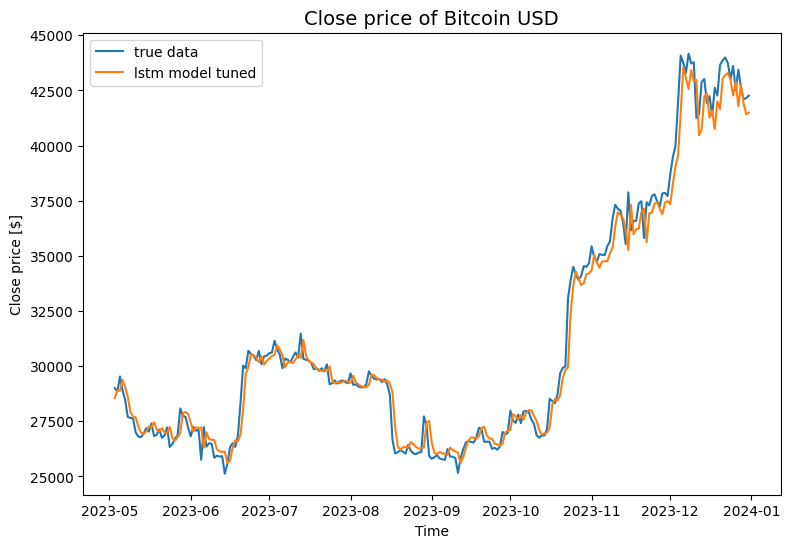

In [44]:
plot_comparison(y_lstm_tuned, y_true, "lstm model tuned")

In [45]:
calculate_errors(y_lstm_tuned, y_true)

,value
MAE,492.741488
RMSE,726.300842


There is an improvement in performance of the LSTM model in terms of both MAE and RMSE. It is very good at estimating the whole period of testset.

### GRU

In [25]:
def gru_hypermodel(hp):

    model = Sequential(name="gru_model_tuned")
    model.add(GRU(50, activation="relu", return_sequences=True, input_shape=X_train[0].shape))
    model.add(Dropout(0.2))
    
    for i in range(hp.Int("gru_layers", 2, 4)):
        model.add(GRU(hp.Int(f"gru_layer_{i}", 10, 50, step=5), activation="relu", return_sequences=True))
    model.add(GRU(50, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="mean_squared_error", optimizer="adam")

    return model

In [26]:
tuner_gru = RandomSearch(gru_hypermodel, objective="loss", 
                         max_trials=5, executions_per_trial=3, 
                         directory="results", project_name="gru")

In [27]:
tuner_gru.search(X_train, y_train, epochs=5, batch_size=1)

Trial 5 Complete [00h 08m 13s]
loss: 0.0014717601394901674

Best loss So Far: 0.0013960549452652533
Total elapsed time: 00h 40m 12s


In [28]:
tuner_gru.hypermodel.build(tuner_gru.get_best_hyperparameters()[0])
tuner_gru.results_summary(num_trials=1)

Results summary
Results in results\gru
Showing 1 best trials
Objective(name="loss", direction="min")

Trial 1 summary
Hyperparameters:
gru_layers: 3
gru_layer_0: 45
gru_layer_1: 20
gru_layer_2: 10
Score: 0.0013960549452652533


In [29]:
gru_model_tuned = gru_hypermodel(tuner_gru.get_best_hyperparameters()[0])
results_gru_tuned = gru_model_tuned.fit(X_train, y_train, epochs=10, batch_size=1)

Epoch 1/10
1118/1118 [==============================] - 36s 29ms/step - loss: 0.0117
Epoch 2/10
1118/1118 [==============================] - 30s 27ms/step - loss: 0.0024
Epoch 3/10
1118/1118 [==============================] - 31s 27ms/step - loss: 0.0018
Epoch 4/10
1118/1118 [==============================] - 32s 28ms/step - loss: 0.0017
Epoch 5/10
1118/1118 [==============================] - 32s 29ms/step - loss: 0.0013
Epoch 6/10
1118/1118 [==============================] - 33s 30ms/step - loss: 0.0012
Epoch 7/10
1118/1118 [==============================] - 32s 28ms/step - loss: 0.0013
Epoch 8/10
1118/1118 [==============================] - 31s 27ms/step - loss: 0.0011
Epoch 9/10
1118/1118 [==============================] - 31s 28ms/step - loss: 0.0012
Epoch 10/10
1118/1118 [==============================] - 30s 27ms/step - loss: 0.0011


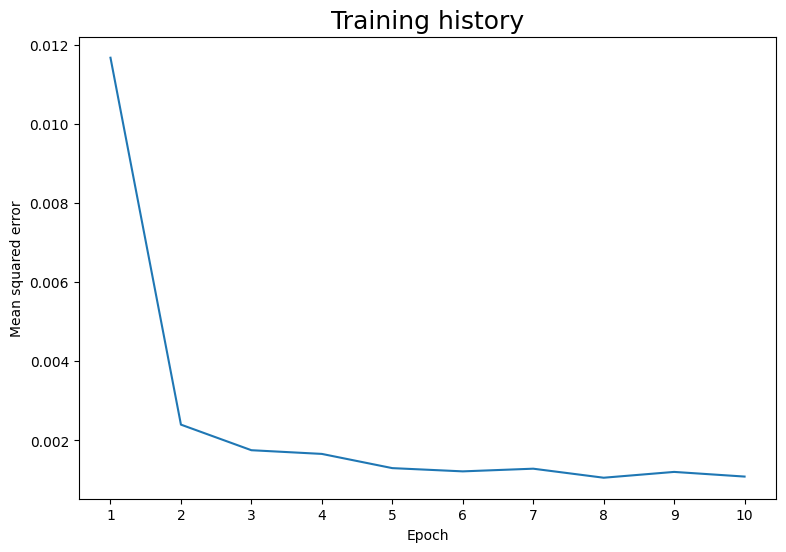

In [30]:
plot_results(results_gru_tuned)

In [31]:
prediction_gru_tuned = gru_model_tuned.predict(X_test)
y_gru_tuned = scaler.inverse_transform(prediction_gru_tuned)

8/8 [==============================] - 1s 12ms/step


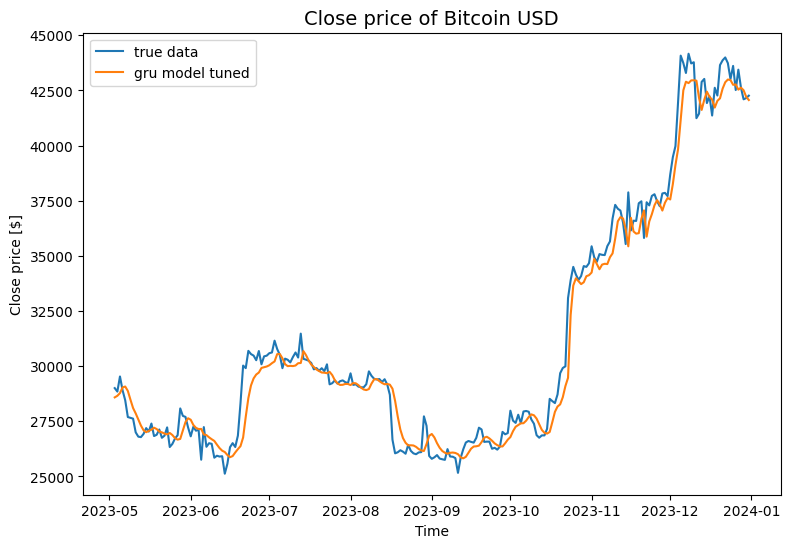

In [32]:
plot_comparison(y_gru_tuned, y_true, "gru model tuned")

In [33]:
calculate_errors(y_gru_tuned, y_true)

,value
MAE,592.270576
RMSE,830.026744


We observe a better performance of the GRU model in terms of both MAE and RMSE.

Overall, the tuned LSTM model seems to be the best suited for this task.